In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as pl

FILE = 'offline_.json'


def scale(x, minv, maxv):
    return ((x - minv) / maxv)
    
def unscale(x, minv, maxv):
    return ((x * maxv) + minv)

In [2]:
offline_data = pd.read_json(FILE)

CycleNumber = offline_data.iloc[1]
CycleType = offline_data.iloc[2]

BVoltage = offline_data.iloc[5]
BCurrent = offline_data.iloc[6]
BTemperature = offline_data.iloc[7]
BCurrentLoad = offline_data.iloc[8]
BVoltageLoad = offline_data.iloc[9]
CycleTime = offline_data.iloc[10]
CycleFinalTime = offline_data.iloc[11]


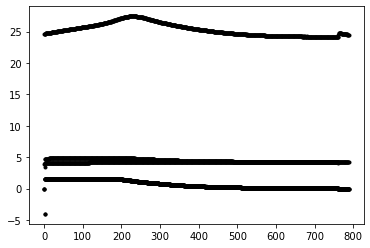

In [3]:
pl.plot(BVoltage[0],'k.')
pl.plot(BCurrent[0],'k.')
pl.plot(BTemperature[0],'k.')
pl.plot(BCurrentLoad[0],'k.')
pl.plot(BVoltageLoad[0],'k.')
#Reject 0 values 
#

In [4]:

# Create two variables, DataSetC and DataSetD, to store charge and discharge data.
# All the cycles will be stored.
# These will be matrices with variables in columns and one data point per row.

NUMBER_INPUTS = 6
LIMIT_DATA = 5

DataSetC = np.empty((0, NUMBER_INPUTS))
DataSetD =  np.empty((0, NUMBER_INPUTS))

for i in CycleNumber:

    # Check your data for potential problems (like outliers).
    # Should we leave any cycles out of the data sets?
    # plots can help.
    
    N = len(BVoltage[i])
    CType = CycleType[i]

    t = np.array(CycleTime[i]).reshape(N,1)
    Vb = np.array(BVoltage[i]).reshape(N,1)
    Ib = np.array(BCurrent[i]).reshape(N,1)
    Tb = np.array(BTemperature[i]).reshape(N,1)
    LIb = np.array(BCurrentLoad[i]).reshape(N,1)
    LVb = np.array(BVoltageLoad[i]).reshape(N,1)
    Tleft = CycleFinalTime[i] - t

    if CType == 'charge':
        DataSetC = np.vstack((DataSetC, np.block([Vb, Ib,Tb,LIb, LVb, Tleft])))
    else:
        DataSetD = np.vstack((DataSetD, np.block([Vb, Ib,Tb, LIb, LVb, Tleft])))

# The two variables have the target output in the last column.
# Should we use all other variables as inputs to the model?
# Could some inputs be redundant?


# Scale all variables to the [0, 1] interval, so the learning algorithms don't get biased
# by the different ranges of values in the variables.

for i in range(DataSetC.shape[1]):
    v = np.hstack((DataSetC[:,i], DataSetD[:,i]))
    
    VMin = v.min()
    VMax = v.max() - VMin

    DataSetC[:,i] = scale(DataSetC[:,i], VMin, VMax)
    DataSetD[:,i] = scale(DataSetD[:,i], VMin, VMax)    

# Shuffle data

Nc = DataSetC.shape[0]
DataSetC = DataSetC[np.random.permutation(Nc), :]
DataSetC = DataSetC[np.random.permutation(Nc), :]

Nd = DataSetD.shape[0]
DataSetD = DataSetD[np.random.permutation(Nd), :]
DataSetD = DataSetD[np.random.permutation(Nd), :]


In [5]:

# Break data set into training and testing data sets
# From the available data which fraction shoud be used for each?
# How many data points to effectively train the models?

TrainSetC = DataSetC[: round(Nc * 0.8), :]
TestSetC = DataSetC[round(Nc * 0.8) :, :]

TrainSetD = DataSetD[: round(Nd * 0.8), :]
TestSetD = DataSetD[round(Nd * 0.8) :, :]

# Train model for charging cycle.
# How many neurons in the first hidden layer?
# How many neurons in the second hidden layer?
# Choose appropriate values for max_iter and tol
# All these parameters and design variable affect the final result.
# Find good compromise

HiddenLayer1 = 15
HiddenLayer2 = 7
modelC = MLPRegressor((HiddenLayer1, HiddenLayer2,), verbose = True, max_iter = 75, tol = 0.0001)
modelC.fit(TrainSetC[:, : LIMIT_DATA], TrainSetC[:, LIMIT_DATA])

YhatC = modelC.predict(TestSetC[:, :LIMIT_DATA])

# Train model for discharging cycle.
# How many neurons in the first hidden layer?
# How many neurons in the second hidden layer?
# Choose appropriate values for max_iter and tol
# All these parameters and design variable affect the final result.
# Find good compromise

HiddenLayer1 = 15
HiddenLayer2 = 7
modelD = MLPRegressor((HiddenLayer1, HiddenLayer2,), verbose = True, max_iter = 75, tol = 0.0001)
modelD.fit(TrainSetD[:, : LIMIT_DATA], TrainSetD[:, LIMIT_DATA])

YhatD = modelD.predict(TestSetD[:, :LIMIT_DATA])


Iteration 1, loss = 0.00584405
Iteration 2, loss = 0.00266147
Iteration 3, loss = 0.00191635
Iteration 4, loss = 0.00144129
Iteration 5, loss = 0.00131123
Iteration 6, loss = 0.00124039
Iteration 7, loss = 0.00123202
Iteration 8, loss = 0.00122989
Iteration 9, loss = 0.00122310
Iteration 10, loss = 0.00121229
Iteration 11, loss = 0.00119929
Iteration 12, loss = 0.00118305
Iteration 13, loss = 0.00117339
Iteration 14, loss = 0.00115475
Iteration 15, loss = 0.00113571
Iteration 16, loss = 0.00111650
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00212283
Iteration 2, loss = 0.00015816
Iteration 3, loss = 0.00014528
Iteration 4, loss = 0.00013496
Iteration 5, loss = 0.00012385
Iteration 6, loss = 0.00011304
Iteration 7, loss = 0.00010128
Iteration 8, loss = 0.00009211
Iteration 9, loss = 0.00008558
Iteration 10, loss = 0.00008104
Iteration 11, loss = 0.00007664
Iteration 12, loss = 0.00007370
Iteration 13, loss = 0.00007109


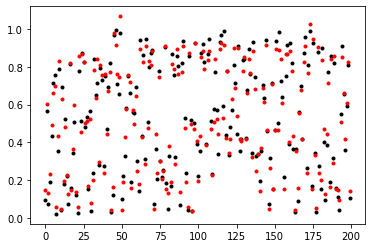

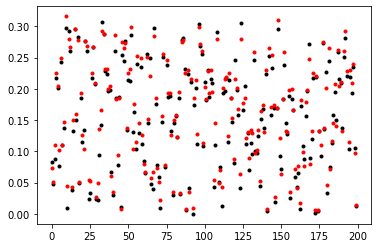

In [6]:

pl.plot(TestSetC[0:200, LIMIT_DATA],'k.')
pl.plot(YhatC[0:200],'r.')
pl.show()

pl.plot(TestSetD[0:200, LIMIT_DATA],'k.')
pl.plot(YhatD[0:200],'r.')
pl.show()

# Visual validation
# The plot should show pairs of red and black dots near each other if the prediction is good

In [7]:

# Numerical validation
# Check also standard deviation

print("Average charge test abs error:",unscale(abs(TestSetC[:,LIMIT_DATA] - YhatC).mean(), VMin, VMax))
print("Average discharge test abs error:",unscale(abs(TestSetD[:,LIMIT_DATA] - YhatD).mean(), VMin, VMax))


Average charge test abs error: 399.84928358375004
Average discharge test abs error: 111.79020990138777


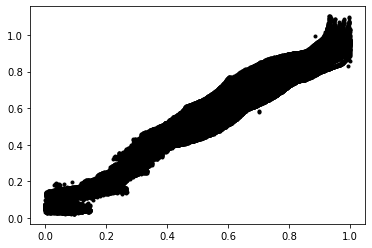

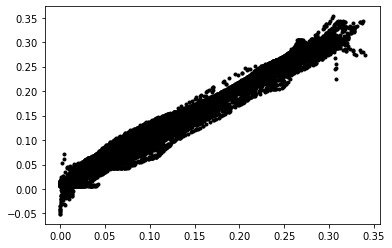

In [8]:
pl.plot(TestSetC[:, LIMIT_DATA], YhatC, 'k.')
pl.show()

pl.plot(TestSetD[:, LIMIT_DATA], YhatD, 'k.')
pl.show()

# This plot shows real (x-axis) versus predicted (y-axis) values.
# Perfect model would show a line from (0,0) to (1,1)

In [9]:
import pickle

fileC = 'modelC.pkl'
with open(fileC,"wb") as file:
    pickle.dump(modelC,file,protocol = 2)
    
fileD = 'modelD.pkl'
with open(fileD,"wb") as file:
    pickle.dump(modelD,file,protocol = 2)